# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

## Nota: Tiempo estimado para ejecutar el notebook: 2:30HS

In [1]:
#librerias generales

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#importante para trabajar

!python -m spacy download es_core_news_md
!pip install wordcloud
!pip install pyspellchecker

#librerias especificas
import nltk
from nltk.tokenize import RegexpTokenizer

import pandas_profiling as pdp

import spacy
from spacy.lang.es.stop_words import STOP_WORDS
import es_core_news_md

import re

from unicodedata import normalize

import gc
gc.enable()

from spellchecker import SpellChecker

from collections import Counter

from wordcloud import WordCloud 

#Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

In [2]:
train= pd.read_json("dataset_es_train.json",lines=True)
print("Shape Train:",train.shape)
print("---------------------------------------------")
dev=pd.read_json("dataset_es_dev.json",lines=True)
print("Shape Dev:",dev.shape)
print("---------------------------------------------")
test=pd.read_json("dataset_es_test.json",lines=True)
print("Shape Test:",test.shape)
print("---------------------------------------------")

Shape Train: (200000, 8)
---------------------------------------------
Shape Dev: (5000, 8)
---------------------------------------------
Shape Test: (5000, 8)
---------------------------------------------


# 1-EDA

Por Motivos de simplificacion en procesamiento, se procede a unir los datos y posteriormente separarlos para su analisis


In [3]:
data=pd.concat([train,dev,test])
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
stars,210000.0,3.0,1.414217,1.0,2.0,3.0,4.0,5.0


In [5]:
data.columns

Index(['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body',
       'review_title', 'language', 'product_category'],
      dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   review_id         210000 non-null  object
 1   product_id        210000 non-null  object
 2   reviewer_id       210000 non-null  object
 3   stars             210000 non-null  int64 
 4   review_body       210000 non-null  object
 5   review_title      210000 non-null  object
 6   language          210000 non-null  object
 7   product_category  210000 non-null  object
dtypes: int64(1), object(7)
memory usage: 14.4+ MB


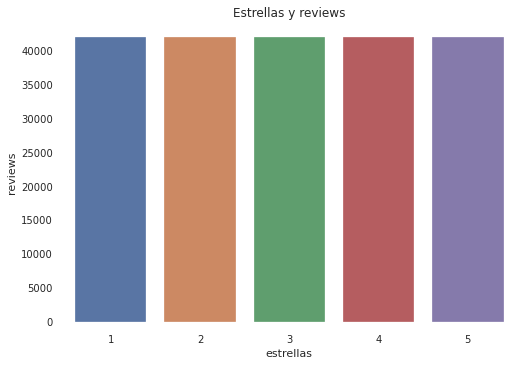

In [7]:
sns.countplot(data=data,x='stars',orient="h")
plt.title("Estrellas y reviews")
plt.xlabel("estrellas")
plt.ylabel("reviews")
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

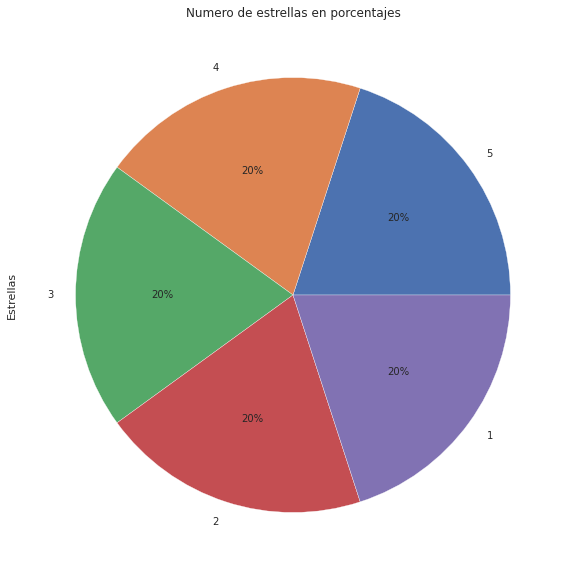

In [8]:
plt.figure(figsize=(10,10))
data.stars.value_counts().plot(kind="pie", autopct='%1.0f%%')
plt.ylabel("Estrellas")

plt.title("Numero de estrellas en porcentajes")
plt.show

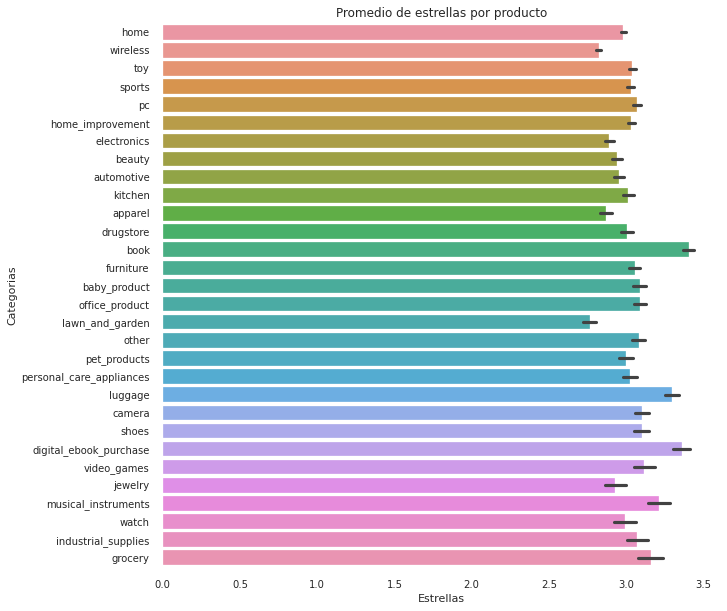

In [9]:
plt.figure(figsize=(10,10))
sns.barplot(x='stars', y='product_category' ,
            data=data,
            order = data.product_category.value_counts().index)

plt.ylabel("Categorias")
plt.xlabel("Estrellas")
plt.title("Promedio de estrellas por producto")
plt.show()

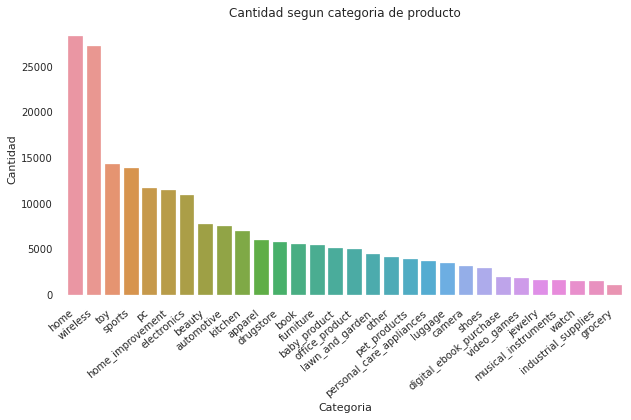

In [10]:
plt.figure(figsize=(10,5))
ax = sns.countplot(data = data, x = "product_category",
                   order = data.product_category.value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation=40,ha="right")
plt.ylabel("Cantidad")
plt.xlabel("Categoria")
plt.title("Cantidad segun categoria de producto")
plt.show()

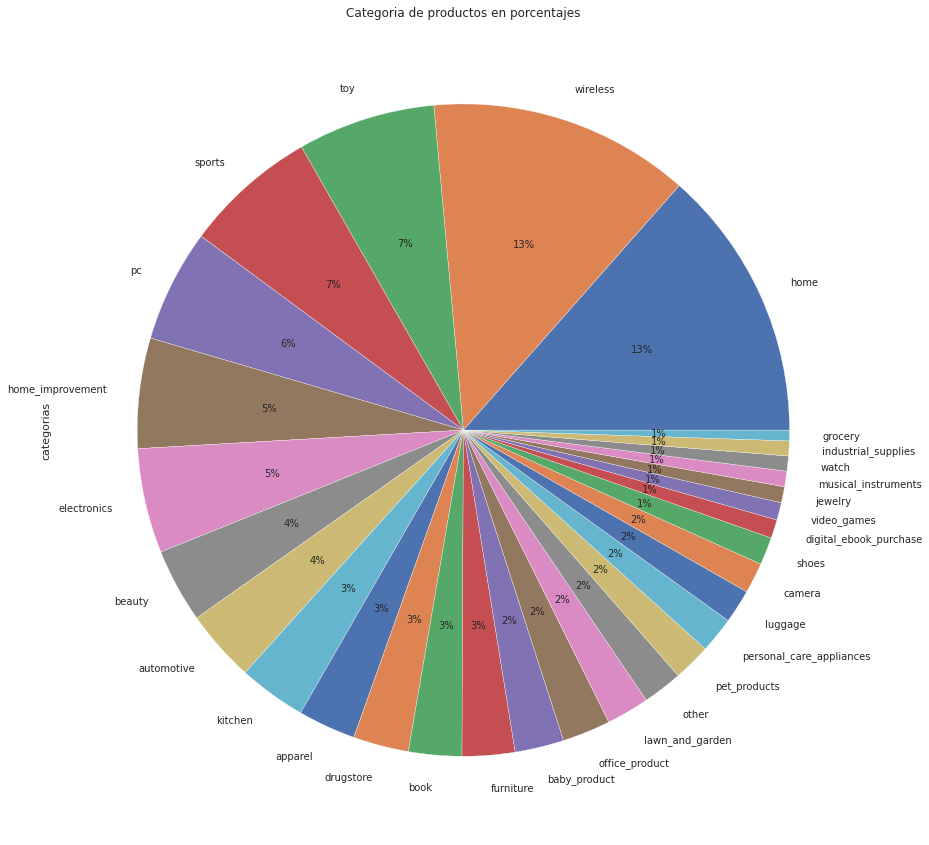

In [11]:
plt.figure(figsize=(22,15))
data.product_category.value_counts().plot(kind="pie", autopct='%1.0f%%')
plt.ylabel("categorias")

plt.title("Categoria de productos en porcentajes")
plt.show()

In [12]:
data.language.unique()

array(['es'], dtype=object)

### Verificacion de valores nulos

In [13]:
data.isna().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

In [14]:
len(data.reviewer_id.unique())

187140

### Analisis en usuario individual

In [15]:
per_user=data["reviewer_id"].value_counts()
per_user

reviewer_es_0437514    7
reviewer_es_0431022    7
reviewer_es_0588051    7
reviewer_es_0475003    6
reviewer_es_0659252    6
                      ..
reviewer_es_0129435    1
reviewer_es_0125766    1
reviewer_es_0910768    1
reviewer_es_0337475    1
reviewer_es_0786230    1
Name: reviewer_id, Length: 187140, dtype: int64

In [16]:
user_unique=data[data.reviewer_id == "reviewer_es_0588051" ]
user_unique

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
82233,es_0673224,product_es_0616815,reviewer_es_0588051,3,"Generó super fino, se notan mucho las costuras...",No me la quede.,es,sports
84353,es_0188523,product_es_0145354,reviewer_es_0588051,3,"Me gusto mucho el tacto , pero el género hacía...",Calidad mediocre.,es,sports
87843,es_0254703,product_es_0420214,reviewer_es_0588051,3,"La idea y el producto yo se ve de calidad , pe...",Buena cosa,es,sports
113208,es_0535895,product_es_0481160,reviewer_es_0588051,3,"Calidad muy buena, pero las tallas no están mu...",No me fue bien la talla,es,pet_products
117067,es_0846764,product_es_0651420,reviewer_es_0588051,3,"Es un poco recio, y le pica el cuello a mi hij...",Normal,es,sports
131219,es_0999442,product_es_0740672,reviewer_es_0588051,4,"Parecía que quedaban bien los cristales, pero ...",Bastante bien,es,kitchen
154756,es_0051525,product_es_0258519,reviewer_es_0588051,4,"Va muy bien , cómodo y discreto",Fenomenal,es,apparel


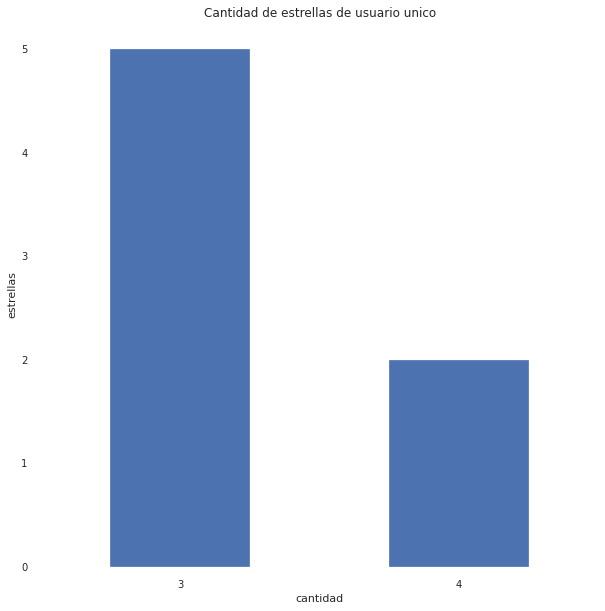

In [17]:
plt.figure(figsize=(10,10))
user_unique.stars.value_counts().plot(kind="bar")
plt.ylabel("estrellas")
plt.xlabel("cantidad")
plt.xticks(rotation=0)
plt.title("Cantidad de estrellas de usuario unico")
plt.show()

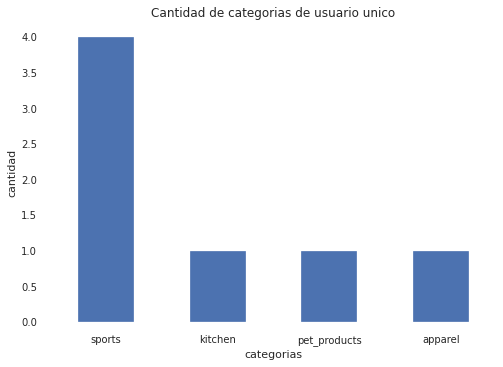

In [18]:
user_unique.product_category.value_counts().plot(kind="bar")
plt.ylabel("cantidad")
plt.xlabel("categorias")
plt.xticks(rotation=0)
plt.title("Cantidad de categorias de usuario unico")
plt.show()

In [19]:
list(user_unique['review_body'])[:5]

['Generó super fino, se notan mucho las costuras y no le fue bien, pero es bonita.',
 'Me gusto mucho el tacto , pero el género hacía bolas en una semana de uso.',
 'La idea y el producto yo se ve de calidad , pero en el envío me llego mal, la tapa no encajaba y así no se puede usar, porque una vez abierto se seca el resto .',
 'Calidad muy buena, pero las tallas no están muy bien . De una a otra es mucha la diferencia.',
 'Es un poco recio, y le pica el cuello a mi hijo ., no me lo quede.']

### procesamiento de datos

Columnas de un solo valor

In [20]:
for i in range(data.shape[1]):
    print(i,len(pd.unique(data.iloc[:,i])))

0 210000
1 156458
2 187140
3 5
4 208127
5 117156
6 1
7 30


Columnas con pocos valores

In [21]:
for i in range(data.shape[1]):
    num=len(pd.unique(data.iloc[:,i]))
    porcentaje=float(num)/data.shape[0]*100
    print("%d, %d, %.1f%%"%(i,num,porcentaje))

0, 210000, 100.0%
1, 156458, 74.5%
2, 187140, 89.1%
3, 5, 0.0%
4, 208127, 99.1%
5, 117156, 55.8%
6, 1, 0.0%
7, 30, 0.0%


Datos duplicados

In [22]:
duplicado = data.duplicated()
print(duplicado.any())
print(data[duplicado])

False
Empty DataFrame
Columns: [review_id, product_id, reviewer_id, stars, review_body, review_title, language, product_category]
Index: []


### Eliminacion de Columnas sin valor

In [23]:
data=data.drop(["review_id","product_id","reviewer_id","language"],axis=1)

In [24]:
data.head()

,stars,review_body,review_title,product_category
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,electronics
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,electronics
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,drugstore
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,wireless
4,1,Llega tarde y co la talla equivocada,Devuelto,shoes


# NLP

#### Preparacion NLP

In [25]:
nlp = es_core_news_md.load() 

#### Preparacion de Stopwords

In [26]:
stopwords_spacy = list(STOP_WORDS)
print(stopwords_spacy)
len(stopwords_spacy)

['contra', 'sería', 'quizás', 'bastante', 'diferentes', 'tiene', 'serán', 'aproximadamente', 'sino', 'mal', 'cuando', 'segun', 'ésa', 'fue', 'sabes', 'tenido', 'ningún', 'poder', 'son', 'sobre', 'momento', 'agregó', 'nuestra', 'cuáles', 'fuimos', 'usas', 'quienes', 'cuánto', 'trabajan', 'fin', 'claro', 'podrian', 'se', 'habia', 'haceis', 'vuestras', 'según', 'anterior', 'gueno', 'tener', 'cuántos', 'aqui', 'más', 'tercera', 'hubo', 'tienen', 'ello', 'quiza', 'trabaja', 'gran', 'teneis', 'eres', 'porque', 'total', 'tuyo', 'menudo', 'qeu', 'fuera', 'míos', 'todavía', 'contigo', 'cuál', 'esas', 'hacia', 'trabajas', 'podriamos', 'dice', 'sabeis', 'da', 'van', 'sigue', 'dónde', 'eran', 'mientras', 'dia', 'estan', 'informó', 'todavia', 'haces', 'aquéllos', 'usais', 'en', 'ex', 'informo', 'atras', 'alguno', 'para', 'sea', 'detrás', 'existe', 'grandes', 'os', 'trabajo', 'intentar', 'pueden', 'buena', 'embargo', 'demás', 'mismas', 'trabajar', 'también', 'trabajais', 'esos', 'mío', 'raras', 'mej

551

In [27]:
nlp = es_core_news_md.load() 
nlp.max_length = 2000000


stop_words=STOP_WORDS
stop_words.remove('peor')
stop_words.remove("bueno")
stop_words.remove("demasiado")
stop_words.remove("buena")
stop_words.remove("buen")
stop_words.remove("buenos")
stop_words.remove("despacio")
stop_words.remove("pocos")
stop_words.remove("poca")
stop_words.remove("bien")
stop_words.remove("raras")
stop_words.remove("ninguno")
stop_words.remove("ningunas")
stop_words.remove("no")
stop_words.remove("si")
stop_words.remove("sí")

## Debido al tiempo que toma este tratamiento en los datos, se procedera a:
    ♦Realizar Tokenizacion, StopWords, Spellcheck y Lemmatizacion.
    ♦Realizar Seleccion de adjetivos
    ♦Guardar todo en un nuevo csv.
    ♦Cargar el csv.
#### Objetivo: evitar 1:20 hs de demora total para el tratamiento de datos

# 1.Haz todas las transformaciones de datos que consideres necesarias.

### Las transformaciones que se realizaron en el dataset, fueron las siguientes:

    A) Eliminacion de todas las tildes,salvo la Ñ. Objetivo: reducir errores ortograficos.

    B) Realizar una tokenizacion eliminando todo aquello que no sean letras.. Objetivo: Eliminacion de signos o caracteres especiales.

    C) Llevar todas las palabras a minuscula. Objetivo: Reducir el trabajo al analizar el texto con palabras que significan lo mismo pero algunas utilizan mayusculas y otras no segun el contexto.

    D) Utilizacion de stopwords. Objetivo: eliminar las palabras con poco valor para el analisis.

    E) Spellcheck. Objetivo: aplicar correccion ortografica en todo el texto.

    F) Spacy. Objetivo: Realizar una tokenizacion.

    G) Lemmatizacion. Objetivo: Trabajar con los lemma de cada palabra.

## <font color=red>Review_title y <font color=green>Review_body

#### Limpieza de tildes,salvo la Ñ en:
## <font color=red>review_title

In [28]:
revs=[]

for i in range(data.shape[0]):
    review = data.iloc[i].review_title 
    review = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", review), 0, re.I
    )
    review=normalize( 'NFC', review)
    revs.append(review)

In [29]:
data["New_R_title"]=pd.Series(revs)

#### Limpieza de tildes,salvo la Ñ en: 
## <font color=green>review_body

In [30]:
revs=[]

for i in range(data.shape[0]):
    review = data.iloc[i].review_body
    review = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", review), 0, re.I
    )
    review=normalize( 'NFC', review)
    revs.append(review)

In [31]:
data["New_R_body"]=pd.Series(revs)

## Spellchecker

In [32]:
spell = SpellChecker(language='es',distance=1)

#### Tokenizacion, StopWords, Spellcheck y Lemmatizacion en:
## <font color=red>review_title (Aprox 20 Min)

In [33]:
def spell_check(x):
    correct_word = []
    mispelled_word = x
    for word in mispelled_word:
        correct_word.append(spell.correction(word))
    return ' '.join(correct_word)

In [34]:
%%time

regexp=RegexpTokenizer(r"\w+")
tokeandstp=[]
data['New_R_title_Lemm'] = ''

for i in range(data.shape[0]):
    review = data.iloc[i].New_R_title
    review = regexp.tokenize(review)
    review = [word.lower() for word in review if word.lower() not in stop_words]
    review = spell_check(review)
    review = nlp(review) 
    review = [word.lemma_ for word in review]
    data['New_R_title_Lemm'].iloc[i] = ' '.join(review)

In [35]:
data.drop("New_R_title",axis=1,inplace=True)

#### Tokenizacion, StopWords, Spellcheck y Lemmatizacion en:
## <font color=green>review_body (Aprox 30 min)

In [36]:
def spell_check(x):
    correct_word = []
    mispelled_word = x
    for word in mispelled_word:
        correct_word.append(spell.correction(word))
    return ' '.join(correct_word)

In [37]:
%%time

tokeandstp=[]
regexp=RegexpTokenizer(r"\w+")
data['New_R_body_Lemm'] = ''

for i in range(data.shape[0]):
    review = data.iloc[i].New_R_body
    review = regexp.tokenize(review) 
    review = [word.lower() for word in review if word.lower() not in stop_words]
    review = spell_check(review)
    review = nlp(review)
    review = [word.lemma_ for word in review]
    data['New_R_body_Lemm'].iloc[i] = ' '.join(review)

In [38]:
data.drop("New_R_body",axis=1,inplace=True)

## Trabajar con Adjetivos

In [39]:
data.isna().sum()

#### Debemos eliminar los NA antes de proseguir.

In [40]:
data = data.dropna(subset=['New_R_title_Lemm',"New_R_body_Lemm"])

## <font color=red>Review_title Adj (aprox 13 min)

In [41]:
%%time

adjetivos = []

for i in range(data.shape[0]):
    review = data.iloc[i].New_R_title_Lemm
    review = nlp(review)
    review = [word for word in review if word.pos_ == "ADJ"]
    adjetivos.append(review)


In [42]:
data["New_R_title_Lemm_ADJ"] = pd.Series(adjetivos)

## <font color=green>Review_Body Adj (aprox 18 min)

In [43]:
%%time


adjetivos = []

for i in range(data.shape[0]):
    review = data.iloc[i].New_R_body_Lemm
    review = nlp(review)
    review = [word for word in review if word.pos_ == "ADJ"]
    adjetivos.append(review)

In [44]:
data["New_R_body_Lemm_ADJ"] = pd.Series(adjetivos)

### Guardado y carga del CSV

In [45]:
data.to_csv('Amazon-Datas1.0.csv', index = False, encoding = 'utf-8')

In [46]:
data = pd.read_csv('Amazon-Datas1.0.csv')

In [47]:
data.head()

,stars,review_body,review_title,product_category,New_R_title_Lemm,New_R_body_Lemm,New_R_title_Lemm_ADJ,New_R_body_Lemm_ADJ
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,electronics,television never,bueno ka pantalla 8 mes y no recibir respuesta...,[],"[bueno, fabricante]"
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,electronics,dinero tirado a basura comprar,horrible tener comprar ingl informático hora c...,[tirado],"[horrible, ingl, informático, capaz]"
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,drugstore,llegar unidad obligar a comprar,obligar a comprar unidad y llegar y no formar ...,[],[autentico]
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,wireless,producto no recibir,no entrar descalificar vendedor mes esperar se...,[],"[amazon, desembolsado, perdido]"
4,1,Llega tarde y co la talla equivocada,Devuelto,shoes,devuelto,llegar y co talla equivocado,[devuelto],[equivocado]


data = pd.read_csv('Amazon-Datas7.0.csv')
data.head()

### Analisis Adjetivos

## <font color=red>Review_title

In [48]:
dfstar1 = data[data.stars == 1]
dfstar2 = data[data.stars == 2]
dfstar3 = data[data.stars == 3]
dfstar4 = data[data.stars == 4]
dfstar5 = data[data.stars == 5]

#### 1 Estrella

In [49]:
dfstar1 = dfstar1.dropna(subset=["New_R_title_Lemm_ADJ"])
dfstar1['New_R_title_Lemm_ADJ']=dfstar1['New_R_title_Lemm_ADJ'].apply(str)

In [50]:
star1 = []
regexp=RegexpTokenizer(r"\w+")

for i in range(dfstar1.shape[0]):
    x = dfstar1.iloc[i].New_R_title_Lemm_ADJ
    x = regexp.tokenize(x) 
    x = [t for t in x if len(t)>1] 
    star1.append(x) 

In [51]:
words_star1=[line for line in star1 for line in set(line)]
words_star1 = Counter(words_star1)
words_star1 = words_star1.most_common(20)
words_star1=pd.DataFrame(words_star1,columns = ['Words', 'Frequency'])
words_star1.head(10)

,Words,Frequency
0,malo,3271
1,roto,852
2,defectuoso,584
3,fatal,576
4,pedido,529
5,malísimo,507
6,pequeño,495
7,recomendable,444
8,decepcionado,426
9,pesimo,411


#### 2 Estrellas

In [52]:
dfstar2.head()

,stars,review_body,review_title,product_category,New_R_title_Lemm,New_R_body_Lemm,New_R_title_Lemm_ADJ,New_R_body_Lemm_ADJ
40000,2,"Los tornillos no ajustan bien, se caen. No lo ...",Regular,toy,regular,tornillo no ajustar bien caer no volveria a co...,[],[]
40001,2,Si haces varias impresiones seguidas aparecen ...,LAS IMPRESIONES NO SON DE MUY BUENA CALIDAD,office_product,impresión no buen calidad,si impresión seguido aparecer borroso zona si ...,[buen],"[seguido, borroso, negro, homogeneo]"
40002,2,es pequeño no coincide con la pantalla del a1,pequeño,wireless,pequeño,pequeño no coincidir pantalla a,[pequeño],[pequeño]
40003,2,No lleva nada para trasportarla y es un poco r...,No lo mandan completo,sports,no mandar completo,no transportar él y rígido,[completo],[rígido]
40004,2,"a ver si me explico , su software reconoce las...",USB 3.0 Adaptador de red de doble banda????,wireless,usb 3 0 adaptador red doble banda,a si explicar software reconocer 2 4 ghb 5 ghb...,[doble],[doble]


In [53]:
dfstar2 = dfstar2.dropna(subset=["New_R_title_Lemm_ADJ"])
dfstar2['New_R_title_Lemm_ADJ']=dfstar2['New_R_title_Lemm_ADJ'].apply(str)

In [54]:
star2 = []
regexp=RegexpTokenizer(r"\w+")

for i in range(dfstar2.shape[0]):
    x = dfstar2.iloc[i].New_R_title_Lemm_ADJ
    x = regexp.tokenize(x) 
    x = [t for t in x if len(t)>1] 
    star2.append(x) 

In [55]:
words_star2=[line for line in star2 for line in set(line)]
words_star2 = Counter(words_star2)
words_star2 = words_star2.most_common(20)
words_star2=pd.DataFrame(words_star2,columns = ['Words', 'Frequency'])
words_star2.head(10)

,Words,Frequency
0,malo,2017
1,pequeño,1172
2,buen,1034
3,roto,548
4,bonito,536
5,decepcionado,453
6,caro,406
7,duro,367
8,defectuoso,340
9,bueno,335


#### 3 estrellas

In [56]:
dfstar3 = dfstar3.dropna(subset=["New_R_title_Lemm_ADJ"])
dfstar3['New_R_title_Lemm_ADJ']=dfstar3['New_R_title_Lemm_ADJ'].apply(str)

In [57]:
star3 = []
regexp=RegexpTokenizer(r"\w+")

for i in range(dfstar3.shape[0]):
    x = dfstar3.iloc[i].New_R_title_Lemm_ADJ
    x = regexp.tokenize(x) 
    x = [t for t in x if len(t)>1] 
    star3.append(x) 

In [58]:
words_star3=[line for line in star3 for line in set(line)]
words_star3 = Counter(words_star3)
words_star3 = words_star3.most_common(20)
words_star3=pd.DataFrame(words_star3,columns = ['Words', 'Frequency'])
words_star3.head(10)

,Words,Frequency
0,buen,2789
1,pequeño,1224
2,bonito,1042
3,correcto,857
4,bueno,764
5,malo,595
6,aceptable,537
7,normal,407
8,memorable,390
9,caro,385


#### 4 Estrellas

In [59]:
dfstar4 = dfstar4.dropna(subset=["New_R_title_Lemm_ADJ"])
dfstar4['New_R_title_Lemm_ADJ']=dfstar4['New_R_title_Lemm_ADJ'].apply(str)

In [60]:
star4 = []
regexp=RegexpTokenizer(r"\w+")

for i in range(dfstar4.shape[0]):
    x = dfstar4.iloc[i].New_R_title_Lemm_ADJ
    x = regexp.tokenize(x) 
    x = [t for t in x if len(t)>1] 
    star4.append(x) 

In [61]:
words_star4=[line for line in star4 for line in set(line)]
words_star4 = Counter(words_star4)
words_star4 = words_star4.most_common(20)
words_star4=pd.DataFrame(words_star4,columns = ['Words', 'Frequency'])
words_star4.head(10)

,Words,Frequency
0,buen,7347
1,perfecto,1444
2,bonito,1271
3,correcto,1143
4,bueno,1141
5,practico,665
6,util,641
7,comodo,610
8,recomendable,564
9,facil,503


#### 5 Estrellas

In [62]:
dfstar5 = dfstar5.dropna(subset=["New_R_title_Lemm_ADJ"])
dfstar5['New_R_title_Lemm_ADJ']=dfstar5['New_R_title_Lemm_ADJ'].apply(str)

In [63]:
star5 = []
regexp=RegexpTokenizer(r"\w+")

for i in range(dfstar5.shape[0]):
    x = dfstar5.iloc[i].New_R_title_Lemm_ADJ
    x = regexp.tokenize(x) 
    x = [t for t in x if len(t)>1] 
    star5.append(x) 

In [64]:
words_star5=[line for line in star5 for line in set(line)]
words_star5 = Counter(words_star5)
words_star5 = words_star5.most_common(20)
words_star5=pd.DataFrame(words_star5,columns = ['Words', 'Frequency'])
words_star5.head(10)

,Words,Frequency
0,buen,6485
1,perfecto,3972
2,genial,1393
3,excelente,1122
4,bonito,1082
5,recomendable,943
6,bueno,935
7,comodo,625
8,practico,581
9,util,556


### Mejorando la Visualizacion

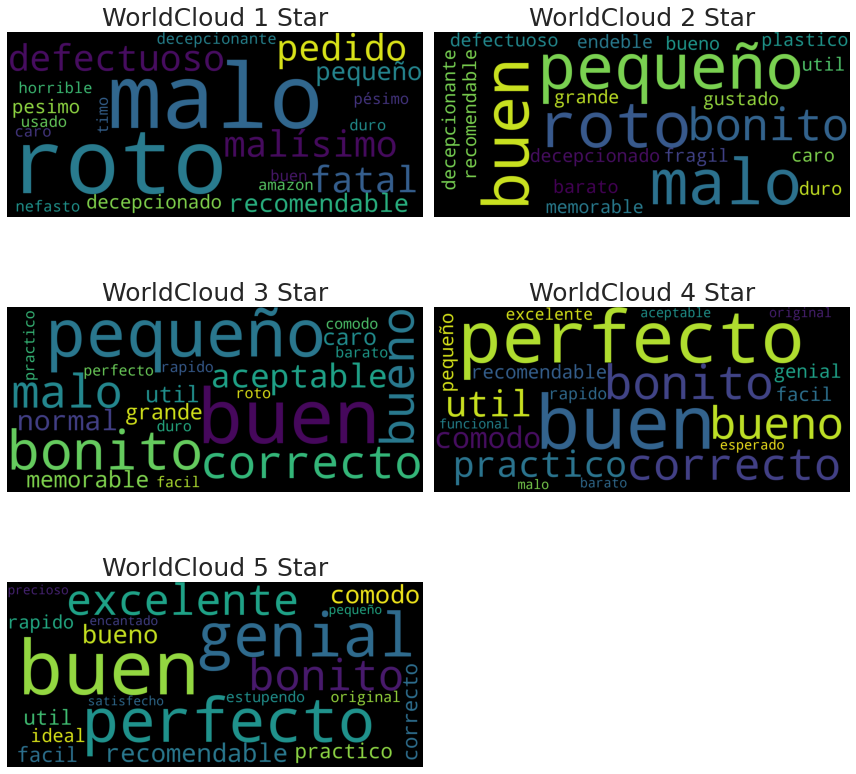

In [65]:
plt.figure(figsize=(12,12))

plt.subplot(321)
estrella1=(" ").join(words_star1["Words"])
wc = WordCloud(max_words = 20, width = 1800 , height = 800 ).generate(estrella1)
plt.imshow(wc)
plt.axis("off")
plt.title('WorldCloud 1 Star', fontsize=25)

plt.subplot(322)
estrella2=(" ").join(words_star2["Words"])
wc = WordCloud(max_words = 20, width = 1800 , height = 800).generate(estrella2)
plt.imshow(wc)
plt.axis("off")
plt.title('WorldCloud 2 Star', fontsize=25)

plt.subplot(323)
estrella3=(" ").join(words_star3["Words"])
wc = WordCloud(max_words = 20, width = 1800 , height = 800).generate(estrella3)
plt.imshow(wc)
plt.axis("off")
plt.title('WorldCloud 3 Star', fontsize=25)

plt.subplot(324)
estrella4=(" ").join(words_star4["Words"])
wc = WordCloud(max_words = 20, width = 1800 , height = 800).generate(estrella4)
plt.imshow(wc)
plt.axis("off")
plt.title('WorldCloud 4 Star', fontsize=25)

plt.subplot(325)
estrella5=(" ").join(words_star5["Words"])
wc = WordCloud(max_words = 20, width = 1800 , height = 800).generate(estrella5)
plt.imshow(wc)
plt.axis("off")
plt.title('WorldCloud 5 Star', fontsize=25)

plt.tight_layout()
plt.show()

## <font color=green>Review_Body

#### 1 Estrella

In [66]:
dfstar1 = dfstar1.dropna(subset=["New_R_body_Lemm_ADJ"])
dfstar1['New_R_body_Lemm_ADJ']=dfstar1['New_R_body_Lemm_ADJ'].apply(str)

In [67]:
star1 = []
regexp=RegexpTokenizer(r"\w+")

for i in range(dfstar1.shape[0]):
    x = dfstar1.iloc[i].New_R_body_Lemm_ADJ
    x = regexp.tokenize(x) 
    x = [t for t in x if len(t)>1] 
    star1.append(x) 

In [68]:
words_star1=[line for line in star1 for line in set(line)]
words_star1 = Counter(words_star1)
words_star1 = words_star1.most_common(20)
words_star1=pd.DataFrame(words_star1,columns = ['Words', 'Frequency'])
words_star1.head(10)

,Words,Frequency
0,malo,3493
1,roto,2303
2,pedido,1941
3,pequeño,1806
4,amazon,1730
5,buen,1458
6,llegado,1371
7,plastico,1145
8,devuelto,1115
9,duro,1077


#### 2 Estrellas

In [69]:
dfstar2 = dfstar2.dropna(subset=["New_R_body_Lemm_ADJ"])
dfstar2['New_R_body_Lemm_ADJ']=dfstar2['New_R_body_Lemm_ADJ'].apply(str)

In [70]:
star2 = []
regexp=RegexpTokenizer(r"\w+")

for i in range(dfstar2.shape[0]):
    x = dfstar2.iloc[i].New_R_body_Lemm_ADJ
    x = regexp.tokenize(x) 
    x = [t for t in x if len(t)>1] 
    star2.append(x) 

In [71]:
words_star2=[line for line in star2 for line in set(line)]
words_star2 = Counter(words_star2)
words_star2 = words_star2.most_common(20)
words_star2=pd.DataFrame(words_star2,columns = ['Words', 'Frequency'])
words_star2.head(10)

,Words,Frequency
0,buen,3317
1,pequeño,3113
2,malo,2544
3,bonito,1918
4,roto,1686
5,plastico,1517
6,duro,1341
7,bueno,1339
8,grande,1139
9,gustado,1013


#### 3 Estrellas

In [72]:
dfstar3 = dfstar3.dropna(subset=["New_R_body_Lemm_ADJ"])
dfstar3['New_R_body_Lemm_ADJ']=dfstar3['New_R_body_Lemm_ADJ'].apply(str)

In [73]:
star3 = []
regexp=RegexpTokenizer(r"\w+")

for i in range(dfstar3.shape[0]):
    x = dfstar3.iloc[i].New_R_body_Lemm_ADJ
    x = regexp.tokenize(x) 
    x = [t for t in x if len(t)>1] 
    star3.append(x) 

In [74]:
words_star3=[line for line in star3 for line in set(line)]
words_star3 = Counter(words_star3)
words_star3 = words_star3.most_common(20)
words_star3=pd.DataFrame(words_star3,columns = ['Words', 'Frequency'])
words_star3.head(10)

,Words,Frequency
0,buen,4929
1,pequeño,3415
2,bonito,2400
3,bueno,1654
4,grande,1596
5,perfecto,1532
6,malo,1413
7,plastico,1366
8,facil,1305
9,unico,1283


#### 4 Estrellas

In [75]:
dfstar4 = dfstar4.dropna(subset=["New_R_body_Lemm_ADJ"])
dfstar4['New_R_body_Lemm_ADJ']=dfstar4['New_R_body_Lemm_ADJ'].apply(str)

In [76]:
star4 = []
regexp=RegexpTokenizer(r"\w+")

for i in range(dfstar4.shape[0]):
    x = dfstar4.iloc[i].New_R_body_Lemm_ADJ
    x = regexp.tokenize(x) 
    x = [t for t in x if len(t)>1] 
    star4.append(x) 

In [77]:
words_star4=[line for line in star4 for line in set(line)]
words_star4 = Counter(words_star4)
words_star4 = words_star4.most_common(20)
words_star4=pd.DataFrame(words_star4,columns = ['Words', 'Frequency'])
words_star4.head(10)

,Words,Frequency
0,buen,9314
1,perfecto,3561
2,unico,2584
3,facil,2519
4,pequeño,2501
5,bonito,2454
6,rapido,1788
7,comodo,1677
8,bueno,1597
9,correcto,1392


#### 5 Estrellas

In [78]:
dfstar5 = dfstar5.dropna(subset=["New_R_body_Lemm_ADJ"])
dfstar5['New_R_body_Lemm_ADJ']=dfstar5['New_R_body_Lemm_ADJ'].apply(str)

In [79]:
star5 = []
regexp=RegexpTokenizer(r"\w+")

for i in range(dfstar5.shape[0]):
    x = dfstar5.iloc[i].New_R_body_Lemm_ADJ
    x = regexp.tokenize(x) 
    x = [t for t in x if len(t)>1] 
    star5.append(x) 

In [80]:
words_star5=[line for line in star5 for line in set(line)]
words_star5 = Counter(words_star5)
words_star5 = words_star5.most_common(20)
words_star5=pd.DataFrame(words_star5,columns = ['Words', 'Frequency'])
words_star5.head(10)

,Words,Frequency
0,buen,9945
1,perfecto,6622
2,facil,3106
3,rapido,2729
4,bonito,2678
5,genial,2411
6,encantado,2112
7,comodo,1956
8,recomendable,1932
9,pequeño,1784


### Mejorando la Visualizacion.

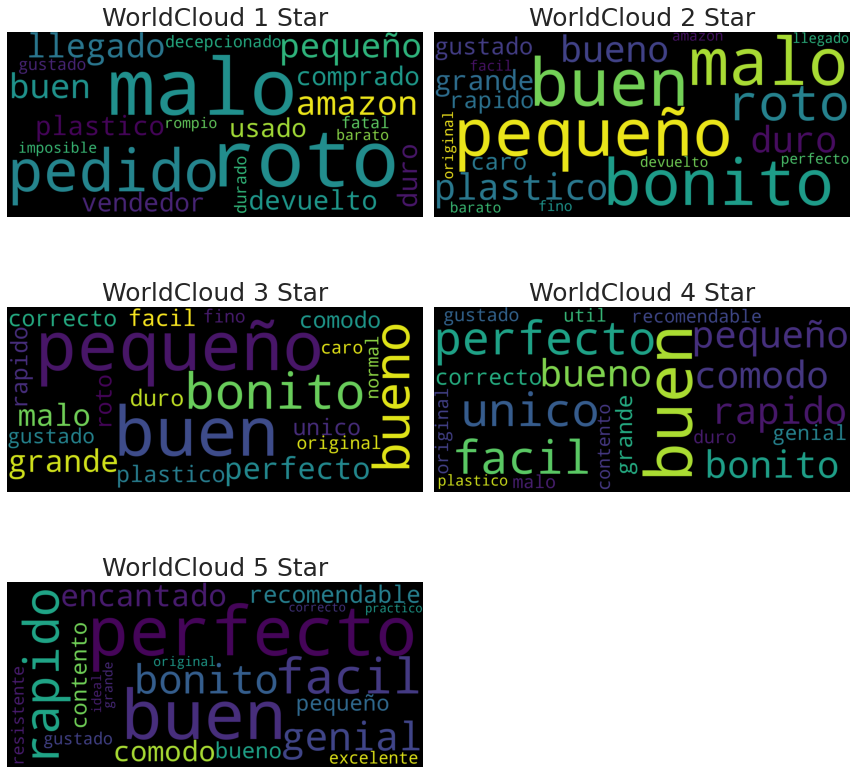

In [81]:
plt.figure(figsize=(12,12))

plt.subplot(321)
estrella1=(" ").join(words_star1["Words"])
wc = WordCloud(max_words = 20, width = 1800 , height = 800 ).generate(estrella1)
plt.imshow(wc)
plt.axis("off")
plt.title('WorldCloud 1 Star', fontsize=25)

plt.subplot(322)
estrella2=(" ").join(words_star2["Words"])
wc = WordCloud(max_words = 20, width = 1800 , height = 800).generate(estrella2)
plt.imshow(wc)
plt.axis("off")
plt.title('WorldCloud 2 Star', fontsize=25)

plt.subplot(323)
estrella3=(" ").join(words_star3["Words"])
wc = WordCloud(max_words = 20, width = 1800 , height = 800).generate(estrella3)
plt.imshow(wc)
plt.axis("off")
plt.title('WorldCloud 3 Star', fontsize=25)

plt.subplot(324)
estrella4=(" ").join(words_star4["Words"])
wc = WordCloud(max_words = 20, width = 1800 , height = 800).generate(estrella4)
plt.imshow(wc)
plt.axis("off")
plt.title('WorldCloud 4 Star', fontsize=25)

plt.subplot(325)
estrella5=(" ").join(words_star5["Words"])
wc = WordCloud(max_words = 20, width = 1800 , height = 800).generate(estrella5)
plt.imshow(wc)
plt.axis("off")
plt.title('WorldCloud 5 Star', fontsize=25)

plt.tight_layout()
plt.show()

### Los Estudios indican que las criticas negativas normalmente incluyen mas palabras que las positivas ¿Sera Verdad?

## <font color=red>Review_title

In [82]:
data['contara_title'] = data["review_title"].apply(lambda x: len(str(x).split()))
data.head()

,stars,review_body,review_title,product_category,New_R_title_Lemm,New_R_body_Lemm,New_R_title_Lemm_ADJ,New_R_body_Lemm_ADJ,contara_title
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,electronics,television never,bueno ka pantalla 8 mes y no recibir respuesta...,[],"[bueno, fabricante]",2
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,electronics,dinero tirado a basura comprar,horrible tener comprar ingl informático hora c...,[tirado],"[horrible, ingl, informático, capaz]",8
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,drugstore,llegar unidad obligar a comprar,obligar a comprar unidad y llegar y no formar ...,[],[autentico],10
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,wireless,producto no recibir,no entrar descalificar vendedor mes esperar se...,[],"[amazon, desembolsado, perdido]",3
4,1,Llega tarde y co la talla equivocada,Devuelto,shoes,devuelto,llegar y co talla equivocado,[devuelto],[equivocado],1


## <font color=green>Review_body

In [83]:
data['contara_body'] = data["review_body"].apply(lambda x: len(str(x).split()))
data.head()

,stars,review_body,review_title,product_category,New_R_title_Lemm,New_R_body_Lemm,New_R_title_Lemm_ADJ,New_R_body_Lemm_ADJ,contara_title,contara_body
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,electronics,television never,bueno ka pantalla 8 mes y no recibir respuesta...,[],"[bueno, fabricante]",2,19
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,electronics,dinero tirado a basura comprar,horrible tener comprar ingl informático hora c...,[tirado],"[horrible, ingl, informático, capaz]",8,23
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,drugstore,llegar unidad obligar a comprar,obligar a comprar unidad y llegar y no formar ...,[],[autentico],10,22
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,wireless,producto no recibir,no entrar descalificar vendedor mes esperar se...,[],"[amazon, desembolsado, perdido]",3,60
4,1,Llega tarde y co la talla equivocada,Devuelto,shoes,devuelto,llegar y co talla equivocado,[devuelto],[equivocado],1,7


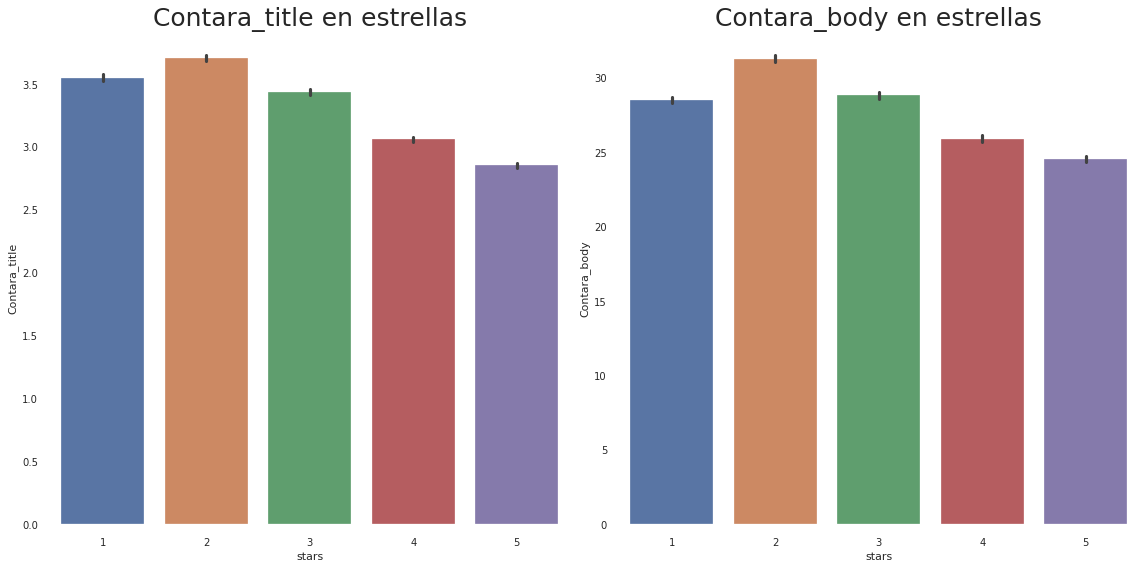

In [84]:
plt.figure(figsize=(16,8))

plt.subplot(121)
sns.barplot(data = data, x = "stars", y = "contara_title")
plt.title('Contara_title en estrellas', fontsize= 25)
plt.xlabel('stars')
plt.ylabel('Contara_title')

plt.subplot(122)
sns.barplot(data = data, x = "stars", y = "contara_body")
plt.title('Contara_body en estrellas', fontsize= 25)
plt.xlabel('stars')
plt.ylabel('Contara_body')

plt.tight_layout()
plt.show()

#### Los resultados indican que las reseñas negativas tienen mas palabras que las positivas.

In [85]:
gc.collect

<function gc.collect(generation=2)>

#### Limpieza de NA

In [86]:
data.isna().sum()

stars                      0
review_body                0
review_title               0
product_category           0
New_R_title_Lemm        3292
New_R_body_Lemm           19
New_R_title_Lemm_ADJ       0
New_R_body_Lemm_ADJ        0
contara_title              0
contara_body               0
dtype: int64

In [87]:
data.dropna(inplace=True)

In [88]:
data.describe()

,stars,contara_title,contara_body
count,206692.000000,206692.000000,206692.000000
mean,3.007368,3.345756,27.892700
std,1.413549,2.527525,24.223703
min,1.000000,1.000000,2.000000
25%,2.000000,2.000000,13.000000
50%,3.000000,3.000000,22.000000
75%,4.000000,4.000000,34.000000
max,5.000000,28.000000,551.000000


# 2-Machine Learning

# 2.Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.

    Para evaluar los resultados se trabajara con Accuracy debido a que el dataset se encuentra perfectamente balanceado, ya que cada estrella representa un 20% del dataset.
    
# 3.Elige un modelo benchmark y compara tus resultados con este modelo.
    
    El Benchmark utilizado es GaussianNB debido a que Naive Bayes suele ser uno de los mejores modelos para NLP.

#### Para la primera prueba solo trabajaremos con lemms

In [89]:
data.head()

,stars,review_body,review_title,product_category,New_R_title_Lemm,New_R_body_Lemm,New_R_title_Lemm_ADJ,New_R_body_Lemm_ADJ,contara_title,contara_body
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,electronics,television never,bueno ka pantalla 8 mes y no recibir respuesta...,[],"[bueno, fabricante]",2,19
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,electronics,dinero tirado a basura comprar,horrible tener comprar ingl informático hora c...,[tirado],"[horrible, ingl, informático, capaz]",8,23
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,drugstore,llegar unidad obligar a comprar,obligar a comprar unidad y llegar y no formar ...,[],[autentico],10,22
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,wireless,producto no recibir,no entrar descalificar vendedor mes esperar se...,[],"[amazon, desembolsado, perdido]",3,60
4,1,Llega tarde y co la talla equivocada,Devuelto,shoes,devuelto,llegar y co talla equivocado,[devuelto],[equivocado],1,7


In [90]:
data_=data.copy()

In [91]:
data_['review_Final'] = data_['New_R_title_Lemm'] + ' ' + data_['New_R_body_Lemm']
data_.head()

,stars,review_body,review_title,product_category,New_R_title_Lemm,New_R_body_Lemm,New_R_title_Lemm_ADJ,New_R_body_Lemm_ADJ,contara_title,contara_body,review_Final
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,electronics,television never,bueno ka pantalla 8 mes y no recibir respuesta...,[],"[bueno, fabricante]",2,19,television never bueno ka pantalla 8 mes y no ...
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,electronics,dinero tirado a basura comprar,horrible tener comprar ingl informático hora c...,[tirado],"[horrible, ingl, informático, capaz]",8,23,dinero tirado a basura comprar horrible tener ...
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,drugstore,llegar unidad obligar a comprar,obligar a comprar unidad y llegar y no formar ...,[],[autentico],10,22,llegar unidad obligar a comprar obligar a comp...
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,wireless,producto no recibir,no entrar descalificar vendedor mes esperar se...,[],"[amazon, desembolsado, perdido]",3,60,producto no recibir no entrar descalificar ven...
4,1,Llega tarde y co la talla equivocada,Devuelto,shoes,devuelto,llegar y co talla equivocado,[devuelto],[equivocado],1,7,devuelto llegar y co talla equivocado


## La siguiente linea toma alrededor de 30 min

In [92]:
%%time

def spell_check(x):
    correct_word = []
    mispelled_word = x
    for word in mispelled_word:
        correct_word.append(spell.correction(word))
    return ' '.join(correct_word)

tokeandstp=[]
regexp=RegexpTokenizer(r"\w+")
data_['New_R_final_Lemm'] = ''

for i in range(data_.shape[0]):
    review = data_.iloc[i].review_Final
    review = regexp.tokenize(review) 
    review = [word.lower() for word in review if word.lower() not in stop_words]
    review = spell_check(review)
    review = nlp(review)
    review = [word.lemma_ for word in review]
    data_['New_R_final_Lemm'].iloc[i] = ' '.join(review)

### Guardado y Carga de CSV

In [93]:
data_.to_csv('Amazon-Datas2.0.csv', index = False, encoding = 'utf-8')

In [94]:
data_ = pd.read_csv('Amazon-Datas2.0.csv')

In [95]:
data_['New_R_final_Lemm'] = data_['New_R_final_Lemm'].apply(str)

data_ = pd.read_csv('Amazon-Datas8.0.csv')

In [96]:
list_revs = list(data_['New_R_final_Lemm'].values)
stars_ = data_["stars"].values

In [97]:
type(list_revs)

list

In [98]:
tfidf = TfidfVectorizer(max_features=1000,lowercase=False)

In [99]:
matriz_revs = tfidf.fit_transform(list_revs)

# Tomamos las palabras
all_words = tfidf.get_feature_names()

# Vizualizamos las 50 palabras mas usadas
print("50 palabras mas usadas: ",all_words[0:50])

50 palabras mas usadas:  ['10', '100', '12', '15', '20', '24', '30', '40', '50', 'abajo', 'abierto', 'abrir', 'absoluto', 'acabado', 'acabar', 'accesorio', 'aceite', 'aceptable', 'acero', 'acierto', 'acolchado', 'aconsejar', 'adaptador', 'adaptar', 'adecuado', 'adherir', 'adhesivo', 'adulto', 'agarrar', 'agarre', 'agradable', 'agua', 'aguantar', 'agujero', 'aguo', 'aire', 'ajustado', 'ajustar', 'ajuste', 'alguien', 'algun', 'altavoz', 'alto', 'altura', 'amarillo', 'amazon', 'amigo', 'amplio', 'ancho', 'andar']


## Modelado

#### Train_Test_Split

In [100]:
x = matriz_revs.toarray()
y = stars_


X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42,stratify=y)

### Funcion para ver Confusion

In [101]:
def confusion(y_test,y_test_pred,X):
    names=["1 estrella","2 estrellas", "3 estrellas", "4 estrellas", "5 estrellas"]
    cm=confusion_matrix(y_test,y_test_pred)
    f,ax=plt.subplots(figsize=(8,8))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.title(X, size = 25)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

### NB (Benchmark)

In [102]:
nb = GaussianNB()
nb.fit(X_train,y_train)

y_train_pred = nb.predict(X_train)
y_test_pred = nb.predict(X_test)

print("Accuracy train GaussianNB: ", accuracy_score(y_train, y_train_pred))
print("Accuracy test GaussianNB: ", accuracy_score(y_test, y_test_pred))

Accuracy train GaussianNB:  0.4233225512150618
Accuracy test GaussianNB:  0.40559282673203456


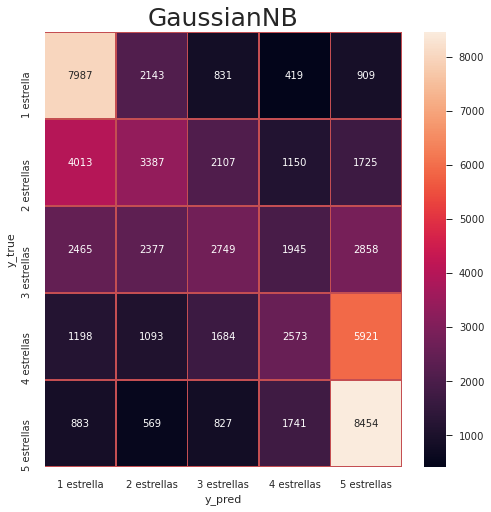

In [103]:
confusion(y_test,y_test_pred,"GaussianNB")

In [104]:
print(classification_report(y_test, y_test_pred)) 

              precision    recall  f1-score   support

           1       0.48      0.65      0.55     12289
           2       0.35      0.27      0.31     12382
           3       0.34      0.22      0.27     12394
           4       0.33      0.21      0.25     12469
           5       0.43      0.68      0.52     12474

    accuracy                           0.41     62008
   macro avg       0.39      0.41      0.38     62008
weighted avg       0.39      0.41      0.38     62008



### LinearSVC

In [105]:
svc = LinearSVC(C = 1)
svc.fit(X_train,y_train)

y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

print("Accuracy train LinearSVC: ", accuracy_score(y_train, y_train_pred))
print("Accuracy test LinearSVC: ", accuracy_score(y_test, y_test_pred))

Accuracy train LinearSVC:  0.5091855353736419
Accuracy test LinearSVC:  0.4918075087085537


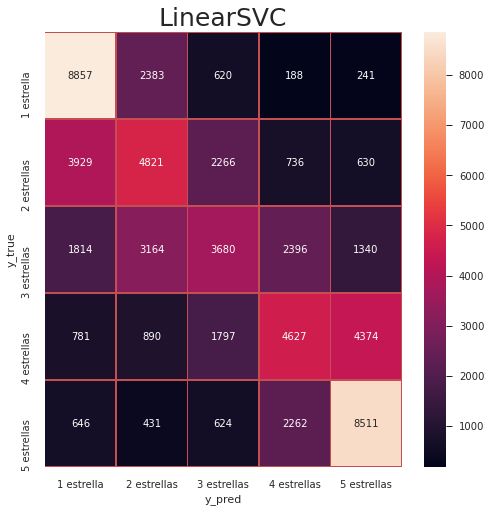

In [106]:
confusion(y_test,y_test_pred,"LinearSVC")

In [107]:
print(classification_report(y_test, y_test_pred)) 

              precision    recall  f1-score   support

           1       0.55      0.72      0.63     12289
           2       0.41      0.39      0.40     12382
           3       0.41      0.30      0.34     12394
           4       0.45      0.37      0.41     12469
           5       0.56      0.68      0.62     12474

    accuracy                           0.49     62008
   macro avg       0.48      0.49      0.48     62008
weighted avg       0.48      0.49      0.48     62008



# 4.Optimiza los hiperparámetros de tu modelo

    Se utiliza GridSearchCV para la optimizacion del LinerarSVC. Solo se trabajara con C.

### LinearSVC Optimizado con Gridsearch

In [108]:
#param_grid = {'C': [0.1,1,3,6] }  
  
#grid = GridSearchCV(svc, param_grid, refit = True, verbose = 3,n_jobs=-1) 

#grid.fit(X_train, y_train) 

In [109]:
#print(grid.best_estimator_) 

In [110]:
#print(grid.best_params_)

In [111]:
svc = LinearSVC(C = 0.1)
svc.fit(X_train,y_train)

y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

print("Accuracy train LinearSVC: ", accuracy_score(y_train, y_train_pred))
print("Accuracy test LinearSVC: ", accuracy_score(y_test, y_test_pred))

Accuracy train LinearSVC:  0.5089781869453429
Accuracy test LinearSVC:  0.49225906334666497


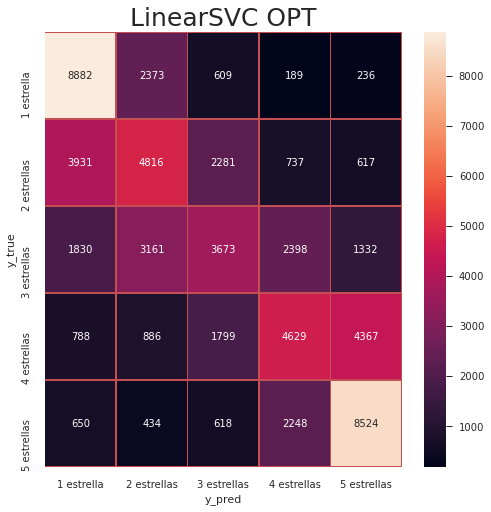

In [112]:
confusion(y_test,y_test_pred,"LinearSVC OPT")

In [113]:
print(classification_report(y_test, y_test_pred)) 

              precision    recall  f1-score   support

           1       0.55      0.72      0.63     12289
           2       0.41      0.39      0.40     12382
           3       0.41      0.30      0.34     12394
           4       0.45      0.37      0.41     12469
           5       0.57      0.68      0.62     12474

    accuracy                           0.49     62008
   macro avg       0.48      0.49      0.48     62008
weighted avg       0.48      0.49      0.48     62008



In [114]:
gc.collect

<function gc.collect(generation=2)>

# 5.Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

#### A continuacion se presentan las palabras que utiliza el LinearSVC para predecir.

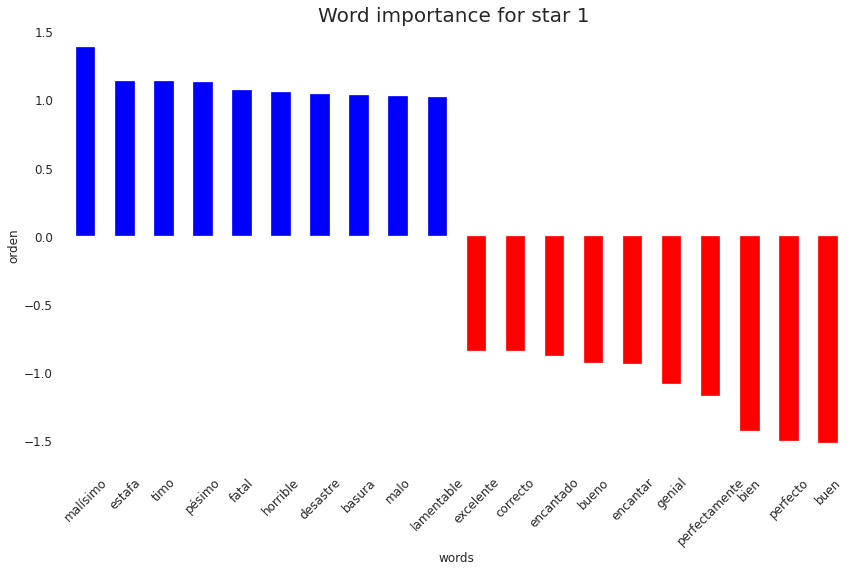

In [115]:
coeff = list(svc.coef_[0])
labels = list(all_words)
importancia = pd.DataFrame()
importancia['words'] = labels
importancia['orden'] = coeff
importancia = importancia.reset_index(drop=True)
orden_imp = importancia.sort_values(by=['orden'], ascending=False)
orden_imp = orden_imp.reset_index(drop=True)
plot = pd.concat([orden_imp.head(10), orden_imp.tail(10)])
plot.sort_values(by=['orden'], ascending=False, inplace = True)
plot['vpos'] = plot['orden'] > 0
plot.set_index('words', inplace = True)
plot.orden.plot(kind='bar', figsize = (14,8),color = plot.vpos.map({True: 'blue', False: 'red'}),fontsize=12,orientation=u'vertical')
plt.xlabel ('words', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel ('orden', rotation = 90, fontsize=12)
plt.title ('Word importance for star 1 ',fontsize=20)
plt.show()

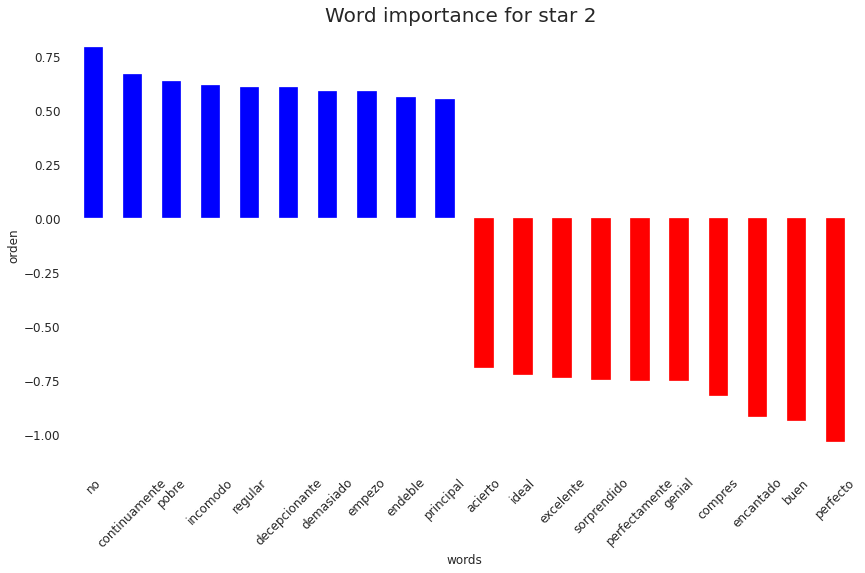

In [116]:
coeff = list(svc.coef_[1])
labels = list(all_words)
importancia = pd.DataFrame()
importancia['words'] = labels
importancia['orden'] = coeff
importancia = importancia.reset_index(drop=True)
orden_imp = importancia.sort_values(by=['orden'], ascending=False)
orden_imp = orden_imp.reset_index(drop=True)
plot = pd.concat([orden_imp.head(10), orden_imp.tail(10)])
plot.sort_values(by=['orden'], ascending=False, inplace = True)
plot['vpos'] = plot['orden'] > 0
plot.set_index('words', inplace = True)
plot.orden.plot(kind='bar', figsize = (14,8),color = plot.vpos.map({True: 'blue', False: 'red'}),fontsize=12,orientation=u'vertical')
plt.xlabel ('words', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel ('orden', rotation = 90, fontsize=12)
plt.title ('Word importance for star 2 ',fontsize=20)
plt.show()

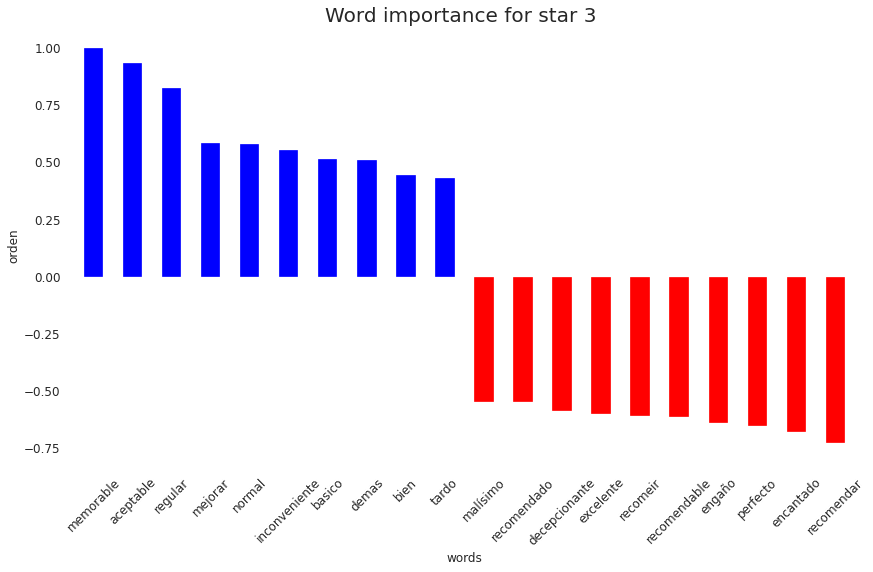

In [117]:
coeff = list(svc.coef_[2])
labels = list(all_words)
importancia = pd.DataFrame()
importancia['words'] = labels
importancia['orden'] = coeff
importancia = importancia.reset_index(drop=True)
orden_imp = importancia.sort_values(by=['orden'], ascending=False)
orden_imp = orden_imp.reset_index(drop=True)
plot = pd.concat([orden_imp.head(10), orden_imp.tail(10)])
plot.sort_values(by=['orden'], ascending=False, inplace = True)
plot['vpos'] = plot['orden'] > 0
plot.set_index('words', inplace = True)
plot.orden.plot(kind='bar', figsize = (14,8),color = plot.vpos.map({True: 'blue', False: 'red'}),fontsize=12,orientation=u'vertical')
plt.xlabel ('words', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel ('orden', rotation = 90, fontsize=12)
plt.title ('Word importance for star 3 ',fontsize=20)
plt.show()

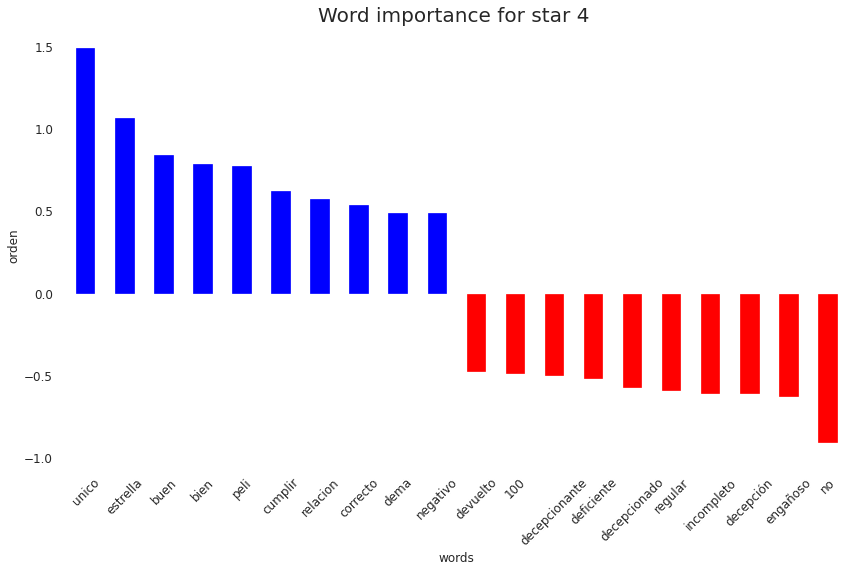

In [118]:
coeff = list(svc.coef_[3])
labels = list(all_words)
importancia = pd.DataFrame()
importancia['words'] = labels
importancia['orden'] = coeff
importancia = importancia.reset_index(drop=True)
orden_imp = importancia.sort_values(by=['orden'], ascending=False)
orden_imp = orden_imp.reset_index(drop=True)
plot = pd.concat([orden_imp.head(10), orden_imp.tail(10)])
plot.sort_values(by=['orden'], ascending=False, inplace = True)
plot['vpos'] = plot['orden'] > 0
plot.set_index('words', inplace = True)
plot.orden.plot(kind='bar', figsize = (14,8),color = plot.vpos.map({True: 'blue', False: 'red'}),fontsize=12,orientation=u'vertical')
plt.xlabel ('words', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel ('orden', rotation = 90, fontsize=12)
plt.title ('Word importance for star 4 ',fontsize=20)
plt.show()

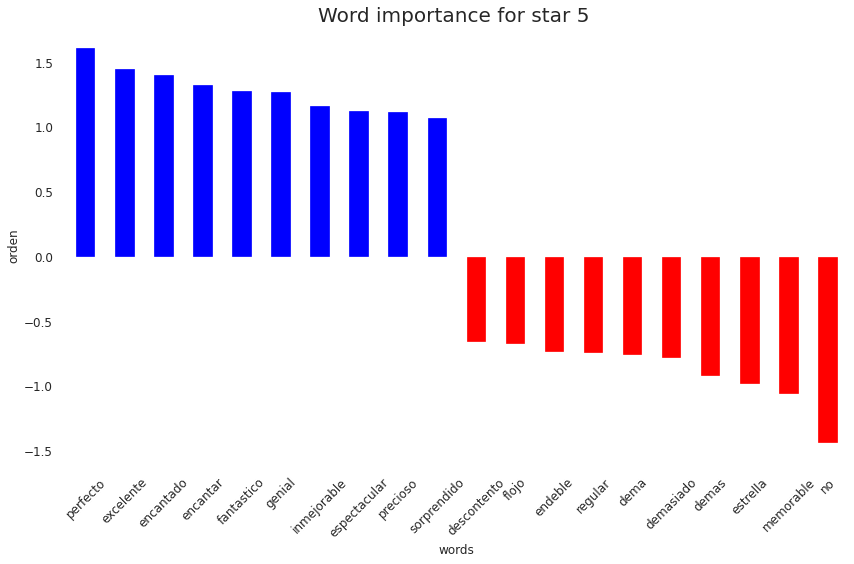

In [119]:
coeff = list(svc.coef_[4])
labels = list(all_words)
importancia = pd.DataFrame()
importancia['words'] = labels
importancia['orden'] = coeff
importancia = importancia.reset_index(drop=True)
orden_imp = importancia.sort_values(by=['orden'], ascending=False)
orden_imp = orden_imp.reset_index(drop=True)
plot = pd.concat([orden_imp.head(10), orden_imp.tail(10)])
plot.sort_values(by=['orden'], ascending=False, inplace = True)
plot['vpos'] = plot['orden'] > 0
plot.set_index('words', inplace = True)
plot.orden.plot(kind='bar', figsize = (14,8),color = plot.vpos.map({True: 'blue', False: 'red'}),fontsize=12,orientation=u'vertical')
plt.xlabel ('words', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel ('orden', rotation = 90, fontsize=12)
plt.title ('Word importance for star 5 ',fontsize=20)
plt.show()

### ¿Hay algo que te gustaría investigar o probar?

    Voy a utilizar redes neuronales para ver si se puede lograr un mejor resultado. 
    Aclaro que es mi primera vez trabajando con las mismas, por lo que el resultado puede no ser el mejor.

## Nota: Para ejecutar las lineas comentadas a partir de este punto se necesita contar con 32gb de RAM. Si este no fuera el caso, se recomienda dejarlas comentadas.

## Redes Neuronales

### Guardado y Carga de CSV

In [120]:
data_.to_csv('Amazon-Datas3.0.csv', index = False, encoding = 'utf-8')

In [121]:
data_ = pd.read_csv('Amazon-Datas3.0.csv')

In [122]:
def confusion(y_test,y_test_pred,X):
    names=["1 estrella","2 estrellas", "3 estrellas", "4 estrellas", "5 estrellas"]
    cm=confusion_matrix(y_test,y_test_pred)
    f,ax=plt.subplots(figsize=(8,8))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.title(X, size = 25)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

In [123]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers.core import SpatialDropout1D
import keras
from keras.layers.convolutional import Conv1D   
from numpy import array
from numpy import asarray
from numpy import zeros

In [124]:
data_['New_R_final_Lemm']=data_['New_R_final_Lemm'].apply(str)

In [125]:
X = data_['New_R_final_Lemm']
y = data_["stars"].values

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

In [127]:
data_.head()

,stars,review_body,review_title,product_category,New_R_title_Lemm,New_R_body_Lemm,New_R_title_Lemm_ADJ,New_R_body_Lemm_ADJ,contara_title,contara_body,review_Final,New_R_final_Lemm
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,electronics,television never,bueno ka pantalla 8 mes y no recibir respuesta...,[],"[bueno, fabricante]",2,19,television never bueno ka pantalla 8 mes y no ...,television never bueno ka pantalla 8 mes y no ...
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,electronics,dinero tirado a basura comprar,horrible tener comprar ingl informático hora c...,[tirado],"[horrible, ingl, informático, capaz]",8,23,dinero tirado a basura comprar horrible tener ...,dinero tirado a basura comprar horrible compra...
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,drugstore,llegar unidad obligar a comprar,obligar a comprar unidad y llegar y no formar ...,[],[autentico],10,22,llegar unidad obligar a comprar obligar a comp...,llegar unidad obligar a comprar obligar a comp...
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,wireless,producto no recibir,no entrar descalificar vendedor mes esperar se...,[],"[amazon, desembolsado, perdido]",3,60,producto no recibir no entrar descalificar ven...,producto no recibir no entrar descalificar ven...
4,1,Llega tarde y co la talla equivocada,Devuelto,shoes,devuelto,llegar y co talla equivocado,[devuelto],[equivocado],1,7,devuelto llegar y co talla equivocado,devuelto llegar y co talla equivocado


In [128]:
data_.shape

(210000, 12)

## Red Neuronal Simple

In [129]:
max_words = 5000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = tokenizer.sequences_to_matrix(X_train, mode='count')
X_test = tokenizer.sequences_to_matrix(X_test, mode='count')


num_classes = max(y_train) + 1

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [130]:
model = Sequential()
model.add(Dense(128, input_shape=(max_words,)))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [131]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
print(model.metrics_names)

[]


In [132]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               640128    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0

In [133]:
batch_size = 128
epochs = 20

In [134]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)

Epoch 1/20
919/919 [==============================] - 7s 6ms/step - loss: 1.7100 - accuracy: 0.2283 - val_loss: 1.4780 - val_accuracy: 0.3700
Epoch 2/20
919/919 [==============================] - 5s 5ms/step - loss: 1.5115 - accuracy: 0.3232 - val_loss: 1.3389 - val_accuracy: 0.4269
Epoch 3/20
919/919 [==============================] - 4s 5ms/step - loss: 1.4046 - accuracy: 0.3692 - val_loss: 1.2760 - val_accuracy: 0.4486
Epoch 4/20
919/919 [==============================] - 4s 5ms/step - loss: 1.3474 - accuracy: 0.3994 - val_loss: 1.2458 - val_accuracy: 0.4618
Epoch 5/20
919/919 [==============================] - 5s 5ms/step - loss: 1.3164 - accuracy: 0.4199 - val_loss: 1.2276 - val_accuracy: 0.4717
Epoch 6/20
919/919 [==============================] - 4s 5ms/step - loss: 1.2958 - accuracy: 0.4316 - val_loss: 1.2136 - val_accuracy: 0.4767
Epoch 7/20
919/919 [==============================] - 5s 6ms/step - loss: 1.2789 - accuracy: 0.4405 - val_loss: 1.2071 - val_accuracy: 0.4808
Epoch 

In [135]:
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

493/493 [==============================] - 2s 4ms/step - loss: 1.1585 - accuracy: 0.5031
Test loss: 1.1585052013397217
Test accuracy: 0.5030634999275208


In [136]:
#y_train_pred = model.predict(X_train)
#y_test_pred = model.predict(X_test)


#y_test=np.argmax(y_test, axis=1)
#y_test_pred=np.argmax(y_test_pred, axis=1)

In [137]:
#confusion(y_test,y_test_pred,"Red simple")

In [138]:
#print(classification_report(y_test, y_test_pred)) 

In [139]:
gc.collect

<function gc.collect(generation=2)>

## Convolucional

In [140]:
X = data_['New_R_final_Lemm']
y = data_["stars"].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

MAX_NB_WORDS = 5000

MAX_SEQUENCE_LENGTH = 250

EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)

tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)



num_classes = max(y_train) + 1

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [141]:
EMBEDDING_DIM=300

In [142]:
model = Sequential()
embedding_layer= (Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(embedding_layer)
model.add(Conv1D(300, 5, activation='relu'))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(150, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [143]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 300)          1500000   
_________________________________________________________________
conv1d (Conv1D)              (None, 246, 300)          450300    
_________________________________________________________________
dropout_3 (Dropout)          (None, 246, 300)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 300)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 150)               45150     
_________________________________________________________________
dropout_5 (Dropout)          (None, 150)              

In [144]:
epochs = 20
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2)

Epoch 1/20
1838/1838 [==============================] - 78s 41ms/step - loss: 1.4035 - acc: 0.3772 - val_loss: 1.1497 - val_acc: 0.5044
Epoch 2/20
1838/1838 [==============================] - 74s 40ms/step - loss: 1.1492 - acc: 0.5085 - val_loss: 1.1384 - val_acc: 0.5016
Epoch 3/20
1838/1838 [==============================] - 75s 41ms/step - loss: 1.1146 - acc: 0.5241 - val_loss: 1.1461 - val_acc: 0.5052
Epoch 4/20
1838/1838 [==============================] - 76s 41ms/step - loss: 1.0868 - acc: 0.5397 - val_loss: 1.1457 - val_acc: 0.5110
Epoch 5/20
1838/1838 [==============================] - 76s 42ms/step - loss: 1.0680 - acc: 0.5472 - val_loss: 1.1528 - val_acc: 0.5044
Epoch 6/20
1838/1838 [==============================] - 75s 41ms/step - loss: 1.0479 - acc: 0.5610 - val_loss: 1.1630 - val_acc: 0.5082
Epoch 7/20
1838/1838 [==============================] - 75s 41ms/step - loss: 1.0256 - acc: 0.5718 - val_loss: 1.1776 - val_acc: 0.5057
Epoch 8/20
1838/1838 [==========================

In [145]:
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

985/985 [==============================] - 10s 10ms/step - loss: 1.3512 - acc: 0.4877
Test loss: 1.3511732816696167
Test accuracy: 0.4876825511455536


In [146]:
#y_train_pred = model.predict(X_train)
#y_test_pred = model.predict(X_test)


#y_test=np.argmax(y_test, axis=1)
#y_test_pred=np.argmax(y_test_pred, axis=1)

In [147]:
#confusion(y_test,y_test_pred,"Red Convolucional")

In [148]:
#print(classification_report(y_test, y_test_pred)) 

### ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?

    El resultado logrado con un modelo binario fue extremadamente mejor. Los modelos pudieron mejorar su clasificacion de una forma muy eficiente. Vale destacar que desde el punto de vista del usuario, realizar puntuaciones en positivo-negativo, en lugar de utilizar estrellas facilita la toma de la decision. 

In [149]:
x = {1 : 0, 2 : 0, 3 : 0, 4 : 1, 5 : 1}

data_['bin'] = data_['stars'].map(x)
data_

,stars,review_body,review_title,product_category,New_R_title_Lemm,New_R_body_Lemm,New_R_title_Lemm_ADJ,New_R_body_Lemm_ADJ,contara_title,contara_body,review_Final,New_R_final_Lemm,bin
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,electronics,television never,bueno ka pantalla 8 mes y no recibir respuesta...,[],"[bueno, fabricante]",2,19,television never bueno ka pantalla 8 mes y no ...,television never bueno ka pantalla 8 mes y no ...,0
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,electronics,dinero tirado a basura comprar,horrible tener comprar ingl informático hora c...,[tirado],"[horrible, ingl, informático, capaz]",8,23,dinero tirado a basura comprar horrible tener ...,dinero tirado a basura comprar horrible compra...,0
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,drugstore,llegar unidad obligar a comprar,obligar a comprar unidad y llegar y no formar ...,[],[autentico],10,22,llegar unidad obligar a comprar obligar a comp...,llegar unidad obligar a comprar obligar a comp...,0
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,wireless,producto no recibir,no entrar descalificar vendedor mes esperar se...,[],"[amazon, desembolsado, perdido]",3,60,producto no recibir no entrar descalificar ven...,producto no recibir no entrar descalificar ven...,0
4,1,Llega tarde y co la talla equivocada,Devuelto,shoes,devuelto,llegar y co talla equivocado,[devuelto],[equivocado],1,7,devuelto llegar y co talla equivocado,devuelto llegar y co talla equivocado,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
209995,5,Para lo que cuesta es perfecto porque cumple s...,Perfectos para lo que sirven,wireless,em,envio nefasto no casa y tirar paquete muro sue...,[],"[nefasto, rompio]",5,28,em envio nefasto no casa y tirar paquete muro ...,em envio nefasto no casa y tirar paquete muro ...,1
209996,5,"Material muy flexible y cómodo, acorde a la de...","Buen vendedor, rápido y fiable.",wireless,no recomendar,calidad pésimo si ser peor estariar hecho pape...,[],"[peor, hecho]",5,9,no recomendar calidad pésimo si ser peor estar...,no recomendar calidad pésimo si peor estario p...,1
209997,5,Se ve bien el grabado,medallas con bonito grabado,home,bonito fragil,maleta gusto infelizmente rompio base rueda viaje,"[bonito, fragil]",[rompio],4,5,bonito fragil maleta gusto infelizmente rompio...,bonito fragil maleta gusto infelizmente rompio...,1
209998,5,lo compré para mi bici pero finalmente se lo h...,timbre,sports,nagore,no convencer no llegar a cubrir pantalla desil...,[nagore],"[perdido, comprado]",1,39,nagore no convencer no llegar a cubrir pantall...,nagore no convencer no llegar a cubrir pantall...,1


In [150]:
def confusion(y_test,y_test_pred,X):
    names=["positivo","negativo"]
    cm=confusion_matrix(y_test,y_test_pred)
    f,ax=plt.subplots(figsize=(8,8))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.title(X, size = 25)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

### LinearSVC

In [151]:
data_['New_R_final_Lemm'] = data_['New_R_final_Lemm'].apply(str)

list_revs = list(data_['New_R_final_Lemm'].values)

tfidf = TfidfVectorizer(max_features=1000,lowercase=False)

matriz_revs = tfidf.fit_transform(list_revs)

# Tomamos las palabras
all_words = tfidf.get_feature_names()

# Vizualizamos las 50 palabras mas usadas
print("50 palabras mas usadas: ",all_words[0:50])

50 palabras mas usadas:  ['10', '100', '12', '15', '20', '24', '30', '40', '50', 'abajo', 'abierto', 'abrir', 'absoluto', 'acabado', 'acabar', 'accesorio', 'aceite', 'aceptable', 'acero', 'acierto', 'acolchado', 'aconsejar', 'adaptador', 'adaptar', 'adecuado', 'adherir', 'adhesivo', 'adulto', 'agarrar', 'agarre', 'agradable', 'agua', 'aguantar', 'agujero', 'aguo', 'aire', 'ajustado', 'ajustar', 'ajuste', 'alguien', 'algun', 'altavoz', 'alto', 'altura', 'amarillo', 'amazon', 'amigo', 'amplio', 'ancho', 'andar']


In [152]:
x = matriz_revs.toarray()
y = data_["bin"].values


X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42,stratify=y)

In [153]:
svc = LinearSVC(C = 1)
svc.fit(X_train,y_train)

y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

print("Accuracy train LinearSVC: ", accuracy_score(y_train, y_train_pred))
print("Accuracy test LinearSVC: ", accuracy_score(y_test, y_test_pred))

Accuracy train LinearSVC:  0.8403469387755103
Accuracy test LinearSVC:  0.8390952380952381


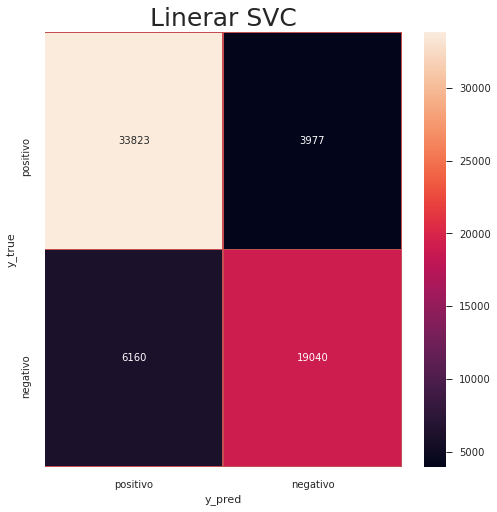

In [154]:
confusion(y_test,y_test_pred,"Linerar SVC")

In [155]:
print(classification_report(y_test, y_test_pred)) 

              precision    recall  f1-score   support

           0       0.85      0.89      0.87     37800
           1       0.83      0.76      0.79     25200

    accuracy                           0.84     63000
   macro avg       0.84      0.83      0.83     63000
weighted avg       0.84      0.84      0.84     63000



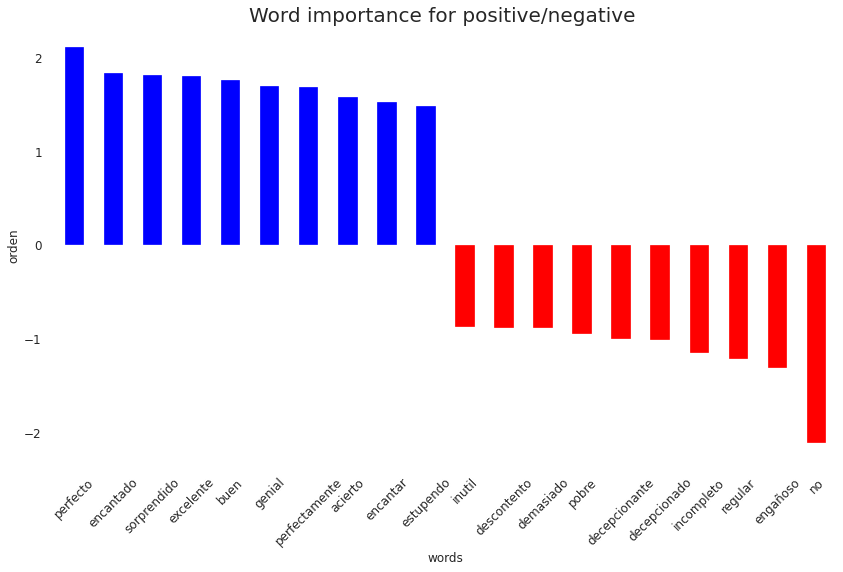

In [156]:
coeff = list(svc.coef_[0])
labels = list(all_words)
importancia = pd.DataFrame()
importancia['words'] = labels
importancia['orden'] = coeff
importancia = importancia.reset_index(drop=True)
orden_imp = importancia.sort_values(by=['orden'], ascending=False)
orden_imp = orden_imp.reset_index(drop=True)
plot = pd.concat([orden_imp.head(10), orden_imp.tail(10)])
plot.sort_values(by=['orden'], ascending=False, inplace = True)
plot['vpos'] = plot['orden'] > 0
plot.set_index('words', inplace = True)
plot.orden.plot(kind='bar', figsize = (14,8),color = plot.vpos.map({True: 'blue', False: 'red'}),fontsize=12,orientation=u'vertical')
plt.xlabel ('words', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel ('orden', rotation = 90, fontsize=12)
plt.title ('Word importance for positive/negative ',fontsize=20)
plt.show()

In [157]:
gc.collect

<function gc.collect(generation=2)>

## Red simple

In [158]:
X = data_['New_R_final_Lemm']
y = data_["bin"].values


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

In [159]:
max_words = 4000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = tokenizer.sequences_to_matrix(X_train, mode='count')
X_test = tokenizer.sequences_to_matrix(X_test, mode='count')


num_classes = max(y_train) + 1

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [160]:
model = Sequential()
model.add(Dense(128, input_shape=(max_words,)))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [161]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.metrics_names)

[]


In [162]:
batch_size = 64
epochs = 20

In [163]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)

Epoch 1/20
1838/1838 [==============================] - 9s 4ms/step - loss: 0.4695 - accuracy: 0.7963 - val_loss: 0.3818 - val_accuracy: 0.8448
Epoch 2/20
1838/1838 [==============================] - 8s 4ms/step - loss: 0.3788 - accuracy: 0.8533 - val_loss: 0.3779 - val_accuracy: 0.8454
Epoch 3/20
1838/1838 [==============================] - 7s 4ms/step - loss: 0.3488 - accuracy: 0.8658 - val_loss: 0.3796 - val_accuracy: 0.8451
Epoch 4/20
1838/1838 [==============================] - 8s 4ms/step - loss: 0.3276 - accuracy: 0.8772 - val_loss: 0.3895 - val_accuracy: 0.8440
Epoch 5/20
1838/1838 [==============================] - 8s 4ms/step - loss: 0.3018 - accuracy: 0.8878 - val_loss: 0.4042 - val_accuracy: 0.8424
Epoch 6/20
1838/1838 [==============================] - 7s 4ms/step - loss: 0.2766 - accuracy: 0.8977 - val_loss: 0.4258 - val_accuracy: 0.8387
Epoch 7/20
1838/1838 [==============================] - 7s 4ms/step - loss: 0.2590 - accuracy: 0.9032 - val_loss: 0.4324 - val_accuracy:

In [164]:
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

985/985 [==============================] - 2s 2ms/step - loss: 0.7046 - accuracy: 0.8346
Test loss: 0.7046470046043396
Test accuracy: 0.8346190452575684


In [165]:
#y_train_pred = model.predict(X_train)
#y_test_pred = model.predict(X_test)


#y_test=np.argmax(y_test, axis=1)
#y_test_pred=np.argmax(y_test_pred, axis=1)

In [166]:
#confusion(y_test,y_test_pred,"Red Simple")

In [167]:
#print(classification_report(y_test, y_test_pred)) 

## Convolucional

In [168]:
X = data_['New_R_final_Lemm']
y = data_["bin"].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

MAX_NB_WORDS = 5000

MAX_SEQUENCE_LENGTH = 250

EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)

tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)



num_classes = max(y_train) + 1

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [169]:
EMBEDDING_DIM=300

In [170]:
model = Sequential()
embedding_layer= (Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(embedding_layer)
model.add(Conv1D(300, 5, activation='relu'))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(150, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [171]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 300)          1500000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 246, 300)          450300    
_________________________________________________________________
dropout_10 (Dropout)         (None, 246, 300)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 150)               45150     
_________________________________________________________________
dropout_12 (Dropout)         (None, 150)              

In [172]:
epochs = 20
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2)

Epoch 1/20
1838/1838 [==============================] - 77s 41ms/step - loss: 0.4681 - acc: 0.7887 - val_loss: 0.3677 - val_acc: 0.8509
Epoch 2/20
1838/1838 [==============================] - 76s 41ms/step - loss: 0.3571 - acc: 0.8603 - val_loss: 0.3693 - val_acc: 0.8528
Epoch 3/20
1838/1838 [==============================] - 73s 40ms/step - loss: 0.3341 - acc: 0.8709 - val_loss: 0.3663 - val_acc: 0.8508
Epoch 4/20
1838/1838 [==============================] - 76s 42ms/step - loss: 0.3147 - acc: 0.8805 - val_loss: 0.3749 - val_acc: 0.8466
Epoch 5/20
1838/1838 [==============================] - 72s 39ms/step - loss: 0.2909 - acc: 0.8927 - val_loss: 0.3903 - val_acc: 0.8455
Epoch 6/20
1838/1838 [==============================] - 77s 42ms/step - loss: 0.2769 - acc: 0.8997 - val_loss: 0.4029 - val_acc: 0.8409
Epoch 7/20
1838/1838 [==============================] - 73s 40ms/step - loss: 0.2597 - acc: 0.9066 - val_loss: 0.4242 - val_acc: 0.8398
Epoch 8/20
1838/1838 [==========================

In [173]:
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

985/985 [==============================] - 10s 11ms/step - loss: 0.5771 - acc: 0.8255
Test loss: 0.577051043510437
Test accuracy: 0.8255397081375122


In [174]:
#y_train_pred = model.predict(X_train)
#y_test_pred = model.predict(X_test)


#y_test=np.argmax(y_test, axis=1)
#y_test_pred=np.argmax(y_test_pred, axis=1)

In [175]:
#confusion(y_test,y_test_pred,"Red Convolucional")

In [176]:
#print(classification_report(y_test, y_test_pred)) 